# Project 4: Analysis of Marathon Results

## Name: Abhishek Kumar Sharma
## Student Id: 5037 2679
## Class: MTH 548
## Date: May 14th, 2023

# Introduction

In this project, We will be working with the dataset "marathon_results.csv". The dataset contains the age, sex, country of the participant. The dataset also contains the finish timings of the participants at different stages of the marathon, their finished positions overall and as per gender, and the division they belong.

Motivation: We want to study the effect of 1-D and 2-D Kernel Density Estimates on our prediction using Naive Bayes model. We want to see if the model's performance is better compared with K-NN model.

We want to study the above dataset and want to create a model in which we compute the 1-D Kernel Density Estimate of male and female runners using finish times, and use it together with the Bayes theorem to compute the probability that a runner with a given time was a female. We also want to implement the same model using the 2-D Kernel Density Estimate. 

We also want to compare accuracy of predictions obtained above to the predictions made using k-NN with the same input data.

Then we also want to use linear regression to predict finish times of runners based on their 5K times and explore any other interesting observation we make during the analysis of the dataset. 

# Background

Kernel Density Estimation often referred to as KDE is a technique that lets you create a smooth curve given a set of data. Kernel density estimates are closely related to histograms but can be endowed with properties such as smoothness or continuity by using a suitable kernel. Using the gaussian KDE we obtain an probablity density function using which we can compute the probablity of an event.

The K-NN or K-nearest neighbors algorithm, is a supervised learning classifier that classifies new information based on its distance from known data. Data can be thought of as n-dimensional vectors where n is the number of data points for each object. We can then compute the distance between a new data vector and all our classified data, and find the k nearest data points, where k is a parameter we can choose to optimize performance.

## Importing Libraries

In [1]:
import pandas as pd                                        # To work with dataframes
import matplotlib.pyplot as plt                            # To plot graphs if required
from collections import Counter
from sklearn.model_selection import train_test_split       # To create the training and test dataset
from bs4 import BeautifulSoup
import numpy as np                                         # To work with array or other mathematical objects
import requests
from tqdm import tqdm
from sklearn.metrics import accuracy_score                  # To check the accuracy score of the model
import json
from datetime import datetime                               # To work with datetime objects
import seaborn as sns                                       # To make graphs or other graphical analysis
from scipy.stats import norm
from ipywidgets import interact, fixed, FloatSlider
from  scipy.stats import gaussian_kde                       # Need this in implementation of 1-D and 2-D KDE implementation
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier          # Since we are allowed to use sklearn implementation of kNN
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression           # To implement linear regression model

## Importing Datasets

We begin by implementing the 1-D KDE for the dataset and then we will implement the Naive Bayes model for the same.

We will create a pandas dataframe which contains our data.

In [2]:
df = pd.read_csv("marathon_results.csv")      # Importing the dataset to pandas dataframe
df.sample(5)

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division
10663,53,M,USA,00:24:51,00:49:02,01:13:16,01:37:41,01:42:59,02:02:14,02:27:37,02:53:39,03:20:19,03:31:44,00:08:05,10700,8007,990
23929,54,M,USA,00:31:06,01:02:23,01:34:14,02:07:06,02:14:05,02:40:43,03:16:24,03:53:44,04:29:38,04:45:13,00:10:53,24155,13531,1914
23248,37,F,USA,00:27:48,00:54:57,01:23:20,01:53:46,01:59:52,02:26:14,03:03:08,03:41:53,04:19:42,04:35:57,00:10:32,23460,10248,5095
15197,46,M,USA,00:24:36,00:48:40,01:12:54,01:37:21,01:42:43,02:01:59,02:27:46,02:56:19,03:32:37,03:46:12,00:08:38,15277,9883,1884
20935,21,F,USA,00:31:24,01:02:53,01:33:30,02:03:59,02:10:35,02:34:53,03:05:02,03:33:26,04:01:54,04:13:58,00:09:42,21104,8942,4600


Since our first aim is to compute the 1-D Kernel Density Estimate of male and female runners using finish times, we compute the finish times in terms of minutes.

In [3]:
df["tot_minutes"] = pd.to_timedelta(df["Finish"]).dt.total_seconds()/60 # Calculating total seconds and converting it into minutes
df.head()

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667


We divide our dataset into two parts. One dataset which contains the data of male runners and a dataset which contains the data of female runners.

In [4]:
dfm = df[df["M/F"] == "M"]  # Dataset containing Male runners
dff = df[df["M/F"] == "F"]  # Dataset containing Female runners

Since KDE are, a non-parametric method to estimate the probability density function of a random variable based on kernels as weights, if we integrate it with a box $$a\leq x\leq b,$$ we will obtain the probablity of satisying the above contition. So we will need a function which computes the integration under KDE. We will use "scipy.stats.gaussian_kde".

In [5]:
from  scipy.stats import gaussian_kde

## Guessing if a runner is a male or a female based on the finish time using 1-D KDE with finish time as input.

In [6]:
kdem = gaussian_kde(dfm["tot_minutes"], bw_method = 0.1)  # KDE for male runners
kdef = gaussian_kde(dff["tot_minutes"], bw_method = 0.1)  # KDE for female runners

Just for observation we plot the graph to compare the finish times of male and female runners.

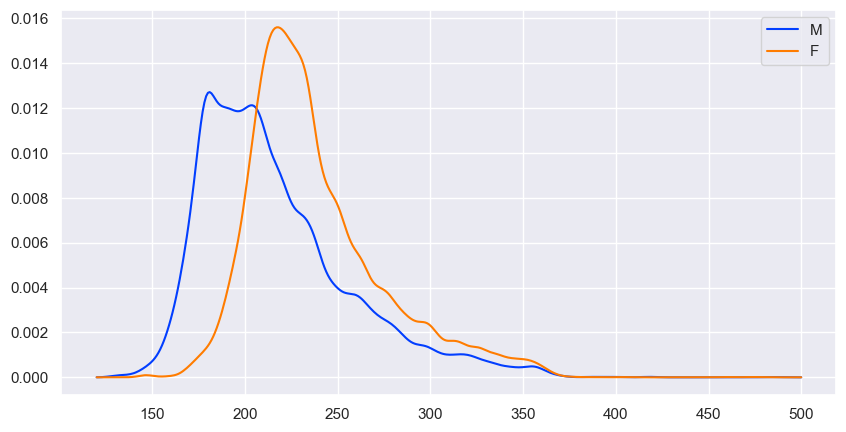

In [7]:
x = np.linspace(120, 500, 400)

plt.figure(figsize = (10, 5))
sns.set_theme(style="darkgrid", palette="bright")
plt.plot(x, kdem(x), label = "M")
plt.plot(x, kdef(x), label = "F")
plt.legend()
plt.show()

Now we will start constructing the Naive Bayes model to predict if the runner is male or female given their finish times. We start by dividing the data into test dataset and training dataset.

In [8]:
train_df, test_df = train_test_split(df,train_size=0.7, test_size = 0.2, random_state=123)

In [9]:
train_df.head(5)

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
12649,22,F,USA,00:24:53,00:49:15,01:13:26,01:38:26,01:43:52,02:04:00,02:30:20,02:57:47,03:25:07,03:37:53,00:08:19,12704,3853,2834,217.883333
24434,40,F,USA,00:32:18,01:04:14,01:36:36,02:12:27,02:19:49,02:51:45,03:27:42,04:05:50,04:40:33,04:55:11,00:11:16,24674,10920,1839,295.183333
11083,47,F,USA,00:24:29,00:48:45,01:13:04,01:37:51,01:43:16,02:02:45,02:28:34,02:56:36,03:22:04,03:33:04,00:08:08,11123,2941,186,213.066667
17255,40,M,USA,00:27:26,00:54:13,01:20:39,01:47:13,01:52:54,02:13:37,02:41:38,03:11:14,03:40:51,03:53:36,00:08:55,17371,10692,1676,233.600000
19524,52,F,CAN,00:28:17,00:56:10,01:24:21,01:53:10,01:59:19,02:21:09,02:50:31,03:22:18,03:52:02,04:04:35,00:09:20,19670,8054,710,244.583333


In [10]:
test_df.head(5)

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,03:08:26,03:36:40,03:48:56,00:08:44,16054,5886,682,228.933333
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,02:20:18,02:42:10,02:51:28,00:06:33,1085,1039,870,171.466667
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,02:13:14,02:33:04,02:42:01,00:06:11,359,343,21,162.016667
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,02:34:10,03:00:20,03:12:22,00:07:21,5149,515,449,192.366667
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,03:11:08,03:37:51,03:49:11,00:08:45,16128,5935,1083,229.183333


In [11]:
dfm = train_df[train_df["M/F"] == "M"]  # Dataset containing Male runners
dff = train_df[train_df["M/F"] == "F"]  # Dataset containing Female runners

kdem = gaussian_kde(dfm["tot_minutes"], bw_method = 0.1)  # KDE for male runners
kdef = gaussian_kde(dff["tot_minutes"], bw_method = 0.1)  # KDE for female runners
kde = gaussian_kde(train_df["tot_minutes"], bw_method = 0.1) #KDE for all runners

In [12]:
def probablity(time):  # This functions calulate the problity of the runner being a male or female give time
    prob_m = np.log10(len(dfm)/len(train_df))   # probablity of a runner being a male
    prob_f = np.log10(len(dff)/len(train_df))   # probablity of a runner being a female
    p_t_m = np.log10(kdem(time))[0]             # probablity of a runner having a finish time given the runner is male
    p_t_f = np.log10(kdef(time))[0]             # probablity of a runner having a finish time given the runner is female
    p_t = np.log10(kde(time))[0]                # probablity of a runner finishing at a given time
    p_m_t = prob_m + p_t_m - p_t                # probablity of a runner being a male given finish time
    p_f_t = prob_f + p_t_f - p_t                # probablity of a runner being a female given finish time
    prod = [p_m_t, p_f_t]
    return prod

In [13]:
predictions = []
for i in range(len(test_df)):
    times = list(test_df["tot_minutes"])
    prob = probablity(times[i])
    if prob[0] > prob[1]:                      # Making predictions if the runner is a male or female using our test data
        predictions.append("M")
    else:
        predictions.append("F")

In [14]:
true_results = test_df["M/F"]

In [15]:
print("The accuracy of the given model is ", accuracy_score(predictions, true_results)*100, "%")

The accuracy of the given model is  65.26615969581749 %


Now lets see how the accuracy of the score changes when we change the training dataset size.

In [16]:
accuracy1D = np.zeros(8)
for i in range(2, 10):
    predictions = []
    train_df, test_df = train_test_split(df, train_size=i/10, test_size = 0.1, random_state=123)
    dfm = train_df[train_df["M/F"] == "M"]  # Dataset containing Male runners
    dff = train_df[train_df["M/F"] == "F"]  # Dataset containing Female runners

    kdem = gaussian_kde(dfm["tot_minutes"], bw_method = 0.1)  # KDE for male runners
    kdef = gaussian_kde(dff["tot_minutes"], bw_method = 0.1)  # KDE for female runners
    kde = gaussian_kde(train_df["tot_minutes"], bw_method = 0.1) #KDE for all runners
    predictions = []
    for j in range(len(test_df)):
        times = list(test_df["tot_minutes"])
        prob = probablity(times[j])
        if prob[0] > prob[1]:                      # Making predictions if the runner is a male or female using our test data
            predictions.append("M")
        else:
            predictions.append("F")
    
    true_results = test_df["M/F"]
    accuracy1D[i-2] = accuracy_score(predictions, true_results)*100

In [17]:
accuracy1D

array([65.81749049, 66.04562738, 65.89353612, 66.23574144, 66.31178707,
       66.3878327 , 66.31178707, 66.3878327 ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


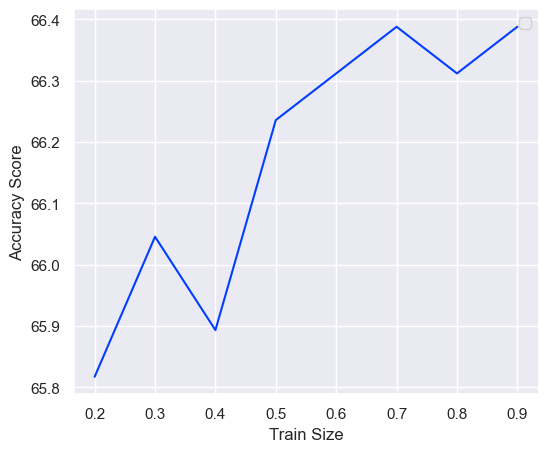

In [18]:
k = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize = (6, 5))
sns.set_theme(style="darkgrid", palette="bright")
plt.plot(k, accuracy1D)
plt.xlabel("Train Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

Therefore we implemented the Naive Bayes model using the 1-D KDE and got the accuracy of the model to be around 65-67%. Now lets see how the performance of the model changes if we implement the Naive Bayes model using 2-D KDE.

## Guessing if a runner is a male or a female based on the finish time and age of the runner using 2-D KDE

In [19]:
train_df, test_df = train_test_split(df,train_size=0.7, test_size = 0.2, random_state=123)

In [20]:
dfm = train_df[train_df["M/F"] == "M"]  # Dataset containing Male runners
dff = train_df[train_df["M/F"] == "F"]  # Dataset containing Female runners

kdem = gaussian_kde(dfm[["tot_minutes", "Age"]].T, bw_method = 0.1)  # 2-D KDE with finish times and age of male runners
kdef = gaussian_kde(dff[["tot_minutes", "Age"]].T, bw_method = 0.1)  # 2-D KDE with finish times and age of female runners
kde = gaussian_kde(train_df[["tot_minutes", "Age"]].T, bw_method = 0.1) # 2-D KDE with finish times and age of for all runners

In [21]:
def probablity(time, age):  # This functions calulate the problity of the runner being a male or female give time
    prob_m = np.log10(len(dfm)/len(train_df))   # probablity of a runner being a male
    prob_f = np.log10(len(dff)/len(train_df))   # probablity of a runner being a female
    p_t_m = np.log10(kdem([time, age]))[0]             # probablity of a runner having a finish time given the runner is male
    p_t_f = np.log10(kdef([time, age]))[0]             # probablity of a runner having a finish time given the runner is female
    p_t = np.log10(kde([time, age]))[0]                # probablity of a runner finishing at a given time and age
    p_m_t = prob_m + p_t_m - p_t                # probablity of a runner being a male given finish time
    p_f_t = prob_f + p_t_f - p_t                # probablity of a runner being a female given finish time
    prod = [p_m_t, p_f_t]
    return prod

In [22]:
predictions = []
for i in range(len(test_df)):
    times = list(test_df["tot_minutes"])
    ages = list(test_df["Age"])
    prob = probablity(times[i], ages[i])
    if prob[0] > prob[1]:                      # Making predictions if the runner is a male or female using our test data
        predictions.append("M")
    else:
        predictions.append("F")

In [23]:
true_results = test_df["M/F"]

In [24]:
print("The accuracy of the given model is ", accuracy_score(predictions, true_results)*100, "%")

The accuracy of the given model is  76.06463878326997 %


Now lets see how the accuracy of the score changes when we change the training dataset size.

In [25]:
accuracy2D = np.zeros(8)
for i in range(2, 10):
    predictions = []
    train_df, test_df = train_test_split(df, train_size=i/10, test_size = 0.1, random_state=123)
    dfm = train_df[train_df["M/F"] == "M"]  # Dataset containing Male runners
    dff = train_df[train_df["M/F"] == "F"]  # Dataset containing Female runners
    kdem = gaussian_kde(dfm[["tot_minutes", "Age"]].T, bw_method = 0.1)  # 2-D KDE with finish times and age of male runners
    kdef = gaussian_kde(dff[["tot_minutes", "Age"]].T, bw_method = 0.1)  # 2-D KDE with finish times and age of female runners
    kde = gaussian_kde(train_df[["tot_minutes", "Age"]].T, bw_method = 0.1) # 2-D KDE with finish times and age of for all runners
    predictions = []
    for j in range(len(test_df)):
        times = list(test_df["tot_minutes"])
        ages = list(test_df["Age"])
        prob = probablity(times[j], ages[j])
        if prob[0] > prob[1]:                      # Making predictions if the runner is a male or female using our test data
            predictions.append("M")
        else:
            predictions.append("F")
    true_results = test_df["M/F"]
    accuracy2D[i-2] = accuracy_score(predictions, true_results)*100

In [26]:
accuracy2D # accuracy2D represents the accuracy of the model with 2D KDE

array([74.37262357, 74.90494297, 74.82889734, 75.36121673, 75.36121673,
       75.39923954, 75.43726236, 75.32319392])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


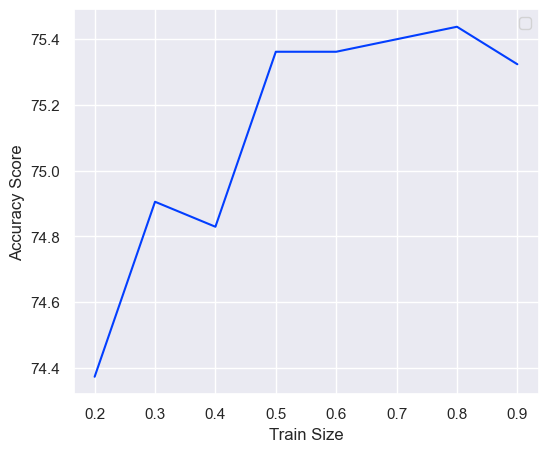

In [27]:
k = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize = (6, 5))
sns.set_theme(style="darkgrid", palette="bright")
plt.plot(k, accuracy2D)
plt.xlabel("Train Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

Therefore we implemented the Naive Bayes model using the 1-D KDE and got the accuracy of the model to be around 74-76%. We observe that from above graph that has the most accuracy when the train size is 80%. In this case, using 2D KDE for the model improves the accuracy of the model by 10 percent points.

## Guessing if a runner is a male or a female based on the finish time using k-NN classifier

Now lets implement the same model using the k-NN model. In this implementation we will use only the age and finish times of the runners as input.

### Implementation with the age and finish times of the runners as input.

In [28]:
new_df = df[["Age", "tot_minutes"]]
new_df = new_df.reset_index(drop = True)

In [29]:
Y = df["M/F"]
Y = Y.reset_index(drop = True)

We start by preprocessing of data. We start by label encoding the "M/F" columns in the dataframe to numerical one so that they can be fitted by our model which only take numerical data.

In [30]:
le = LabelEncoder()
y = le.fit_transform(Y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(new_df, Y, test_size=0.2) # Splitting the dataset into test and training data

In [32]:
classifier = KNeighborsClassifier(n_neighbors=5, metric = "euclidean", p = 2)   # Creating the kNN Classifier with k = 5

In [33]:
classifier.fit(X_train, y_train)    # Training our k-NN model

KNeighborsClassifier(metric='euclidean')

In [34]:
y_pred = classifier.predict(X_test) # Using the trained model now we are classifying the test dataset

In [35]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred)*100)

Accuracy Score:  73.07984790874525


Now lets see how the accuracy of the score changes when we change the training dataset size.

In [36]:
accuracy_kNN = np.zeros(8)
for i in range(2, 10):
    predictions = []
    le = LabelEncoder()
    y = le.fit_transform(Y)
    X_train, X_test, y_train, y_test = train_test_split(new_df, Y, train_size = i/10, test_size=0.1, random_state = 123)
    classifier = KNeighborsClassifier(n_neighbors=5, metric = "euclidean", p = 2)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_kNN[i-2] = accuracy_score(y_test, y_pred)*100

In [37]:
accuracy_kNN

array([72.39543726, 73.00380228, 73.30798479, 72.96577947, 72.20532319,
       72.47148289, 72.81368821, 72.66159696])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


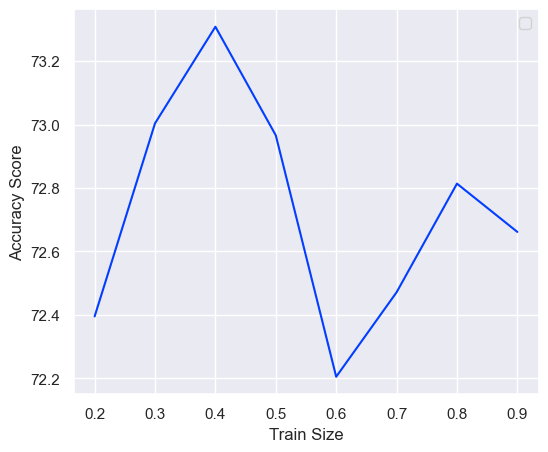

In [38]:
k = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize = (6, 5))
sns.set_theme(style="darkgrid", palette="bright")
plt.plot(k, accuracy_kNN)
plt.xlabel("Train Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

We can observe that the accuracy of the model is oscillating between 72-74% as we are increasing the size of the training data. As another exmaple lets see how the accuracy of the model changes when we increase the number of neighbours.

In [39]:
accuracy_kNN_n = np.zeros(15)
for i in range(2, 17):
    predictions = []
    le = LabelEncoder()
    y = le.fit_transform(Y)
    X_train, X_test, y_train, y_test = train_test_split(new_df, Y, train_size = 0.8, test_size=0.1, random_state = 123)
    classifier = KNeighborsClassifier(n_neighbors=2*i-1, metric = "euclidean", p = 2)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_kNN_n[i-2] = accuracy_score(y_test, y_pred)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


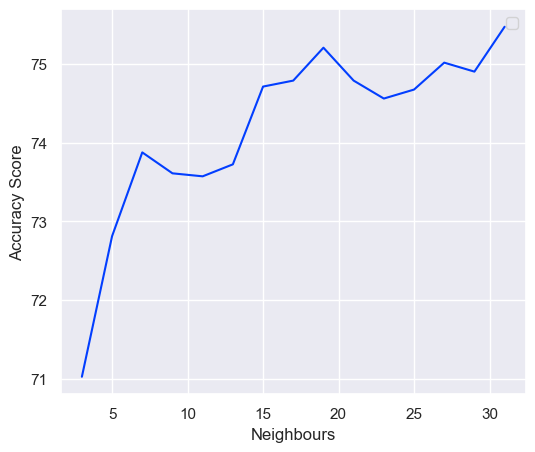

In [40]:
k = list(range(3, 32, 2))
plt.figure(figsize = (6, 5))
sns.set_theme(style="darkgrid", palette="bright")
plt.plot(k, accuracy_kNN_n)
plt.xlabel("Neighbours")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

We can see that as we increase the number of neigbours, the accuracy of the model in increasing with some fluctuations. The accuracy of the model is lying between 72-76%.

### Implementation with the finish times of the runners as input

In [41]:
new_df = df[["tot_minutes"]]
new_df = new_df.reset_index(drop = True)
Y = df["M/F"]
Y = Y.reset_index(drop = True)

In [42]:
accuracy_kNN_1 = np.zeros(8)
for i in range(2, 10):
    predictions = []
    le = LabelEncoder()
    y = le.fit_transform(Y)
    X_train, X_test, y_train, y_test = train_test_split(new_df, Y, train_size = i/10, test_size=0.1, random_state = 123)
    classifier = KNeighborsClassifier(n_neighbors=5, metric = "euclidean", p = 2) # We are using euclidean distance for compute the neighbours
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_kNN_1[i-2] = accuracy_score(y_test, y_pred)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


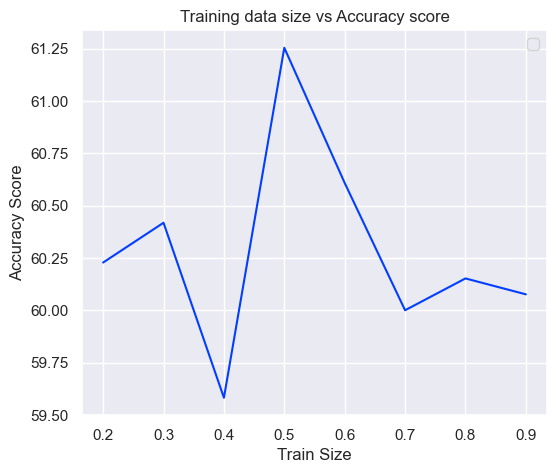

In [43]:
k = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize = (6, 5))
sns.set_theme(style="darkgrid", palette="bright")
plt.plot(k, accuracy_kNN_1)
plt.xlabel("Train Size")
plt.ylabel("Accuracy Score")
plt.title('Training data size vs Accuracy score')
plt.legend()
plt.show()

As we can observe, the accuracy of the model decreases as compared to the kNN classifier with age and tot_minutes as inputs.

## Compare accuracy of predictions obtained in parts 1 and 2 to the predictions made using k-NN with the same input data.

We will first compare the accuracy of 2D KDE and k-NN model where age and tot_minutes were given as input data in the training dataset. 

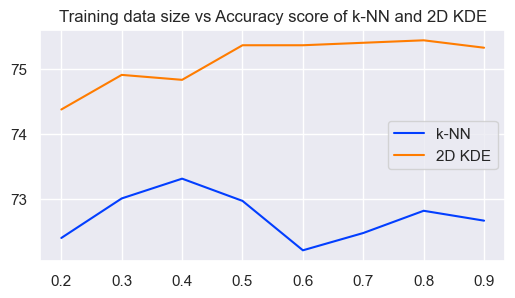

In [44]:
k = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize=(6, 3))
plt.plot(k, accuracy_kNN, label = "k-NN")
plt.plot(k, accuracy2D, label = "2D KDE")
plt.title('Training data size vs Accuracy score of k-NN and 2D KDE')
plt.legend();

We now compare the accuracy of 2D KDE and k-NN model where tot_minutes were given as input data in the training dataset. 

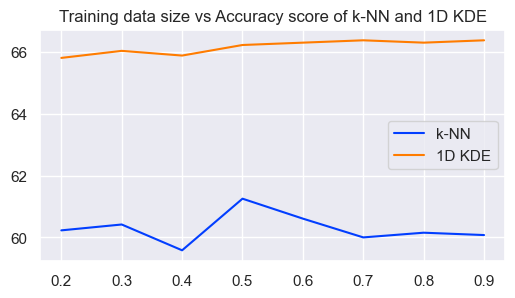

In [45]:
k = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize=(6, 3))
plt.plot(k, accuracy_kNN_1, label = "k-NN")
plt.plot(k, accuracy1D, label = "1D KDE")
plt.title('Training data size vs Accuracy score of k-NN and 1D KDE')
plt.legend();

In both the cases we can observe that the KDE models outperform k-NN models. 

## Use linear regression to predict finish times of runners based on their 5K times.

Our aim is to use linear regression to predict finish times of runners based on their 5K times. Evaluate accuracy of these predictions. Then use other data beside the 5K time (the age of a runner, whether the runner was a male or a female) together with the 5K times to predict finish times using linear regression, and check if this meaningfully improves the predictions.

We have the following data of mathathon results:

In [46]:
df.head()

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667


We start by computing the 5K times of the runners in terms of minutes.

In [47]:
df["5k_minutes"] = pd.to_timedelta(df["5K"]).dt.total_seconds()/60 # Calculating total seconds and converting it into minutes
df.head()

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333,14.716667
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000,14.716667
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667,14.716667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333,14.716667
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667,14.716667


Now lets start our development of the required linear regression model.

In [48]:
reg = LinearRegression()      # We are using sklearn as it is mentioned that we can use sklearn for Linear Regression

In [49]:
train_df, test_df = train_test_split(df,train_size=0.7, test_size = 0.2, random_state=123)

In [50]:
train_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_minutes
12649,22,F,USA,00:24:53,00:49:15,01:13:26,01:38:26,01:43:52,02:04:00,02:30:20,02:57:47,03:25:07,03:37:53,00:08:19,12704,3853,2834,217.883333,24.883333
24434,40,F,USA,00:32:18,01:04:14,01:36:36,02:12:27,02:19:49,02:51:45,03:27:42,04:05:50,04:40:33,04:55:11,00:11:16,24674,10920,1839,295.183333,32.300000
11083,47,F,USA,00:24:29,00:48:45,01:13:04,01:37:51,01:43:16,02:02:45,02:28:34,02:56:36,03:22:04,03:33:04,00:08:08,11123,2941,186,213.066667,24.483333
17255,40,M,USA,00:27:26,00:54:13,01:20:39,01:47:13,01:52:54,02:13:37,02:41:38,03:11:14,03:40:51,03:53:36,00:08:55,17371,10692,1676,233.600000,27.433333
19524,52,F,CAN,00:28:17,00:56:10,01:24:21,01:53:10,01:59:19,02:21:09,02:50:31,03:22:18,03:52:02,04:04:35,00:09:20,19670,8054,710,244.583333,28.283333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14519,27,F,USA,00:24:21,00:49:20,01:15:40,01:41:40,01:47:21,02:08:23,02:35:58,03:03:32,03:31:25,03:43:49,00:08:33,14594,4972,3365,223.816667,24.350000
16527,60,M,USA,00:26:05,00:52:00,01:18:51,01:45:17,01:50:56,02:11:41,02:39:03,03:08:07,03:37:32,03:51:05,00:08:49,16636,10399,313,231.083333,26.083333
24787,31,F,USA,00:32:34,01:04:02,01:36:51,02:11:24,02:18:46,02:47:20,03:25:35,04:06:08,04:44:54,05:02:15,00:11:32,25032,11134,5540,302.250000,32.566667
12006,33,F,CAN,00:25:39,00:50:34,01:15:32,01:40:14,01:45:40,02:05:36,02:31:44,02:57:48,03:24:09,03:35:50,00:08:14,12056,3483,2618,215.833333,25.650000


In [51]:
reg.fit(train_df[['5k_minutes']], train_df['tot_minutes'])  # Training the model with training dataset

LinearRegression()

In [52]:
reg.coef_   # Coefficient of x in the equation of the line

array([9.17674961])

In [53]:
reg.intercept_    # Value of the interceot at y-axis

-8.203221653275705

Using the coefficient of x and y intercept, we know the equation of the line with least mean squared error for the training data. Now lets look at a graph.

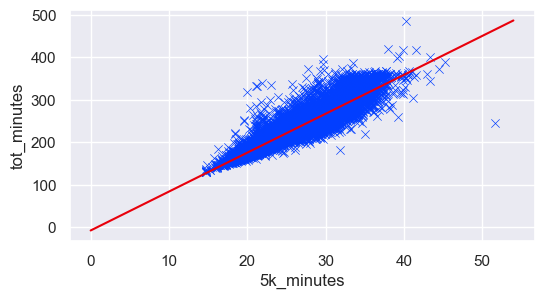

In [54]:
plt.figure(figsize=(6, 3))
sns.scatterplot(data=train_df, x='5k_minutes', y='tot_minutes', marker='x')
x = np.arange(0, 55)
plt.plot(x, reg.coef_[0]*x + reg.intercept_, c='r');

Now using the above line we can try to predict the finish time of the runners in the test dataset.

In [55]:
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_minutes
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,03:08:26,03:36:40,03:48:56,00:08:44,16054,5886,682,228.933333,27.516667
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,02:20:18,02:42:10,02:51:28,00:06:33,1085,1039,870,171.466667,18.500000
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,02:13:14,02:33:04,02:42:01,00:06:11,359,343,21,162.016667,18.516667
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,02:34:10,03:00:20,03:12:22,00:07:21,5149,515,449,192.366667,20.316667
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,03:11:08,03:37:51,03:49:11,00:08:45,16128,5935,1083,229.183333,25.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,02:12:29,02:31:21,02:39:59,00:06:07,271,257,239,159.983333,18.916667
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,03:53:07,04:41:28,04:57:43,00:11:22,24817,13811,1410,297.716667,29.483333
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,02:39:42,03:01:52,03:11:55,00:07:20,5046,4559,2855,191.916667,22.200000
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,03:05:51,03:36:46,03:48:55,00:08:44,16048,10167,1493,228.916667,24.233333


We start by computing the predictions of finish times in minutes according to our model.

In [56]:
test_df["regression"] = reg.predict(test_df[['5k_minutes']])

Now lets see how much error we get for each runner as compared to the actutal finish times.

In [57]:
test_df['regression_error'] = test_df['regression'] - df['tot_minutes']
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_minutes,regression,regression_error
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,03:36:40,03:48:56,00:08:44,16054,5886,682,228.933333,27.516667,244.310339,15.377005
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,02:42:10,02:51:28,00:06:33,1085,1039,870,171.466667,18.500000,161.566646,-9.900020
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,02:33:04,02:42:01,00:06:11,359,343,21,162.016667,18.516667,161.719592,-0.297075
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,03:00:20,03:12:22,00:07:21,5149,515,449,192.366667,20.316667,178.237741,-14.128925
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,03:37:51,03:49:11,00:08:45,16128,5935,1083,229.183333,25.033333,221.521410,-7.661923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,...,02:31:21,02:39:59,00:06:07,271,257,239,159.983333,18.916667,165.390292,5.406959
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,...,04:41:28,04:57:43,00:11:22,24817,13811,1410,297.716667,29.483333,262.357946,-35.358721
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,...,03:01:52,03:11:55,00:07:20,5046,4559,2855,191.916667,22.200000,195.520620,3.603953
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,...,03:36:46,03:48:55,00:08:44,16048,10167,1493,228.916667,24.233333,214.180011,-14.736656


In the above dataframe the column "regression_error" gives us the difference between the predicted time and the actual time.

In [58]:
test_df['regression_error'].mean()    # Mean error of the predictions

0.04754198839318631

In [59]:
np.abs(test_df['regression_error']).describe() # The absolute mean, standatard deviation, min error, max error and other details

count    5260.000000
mean       11.079295
std        11.438981
min         0.001620
25%         3.878543
50%         7.824158
75%        14.055967
max       132.496739
Name: regression_error, dtype: float64

So in the above linear regression model the mean absolute error is about 11 minutes with standard deviation of about 11.5 minutes. Lets see the graph of gaussian distribution of the errors.

In [60]:
mean = np.abs(test_df['regression_error']).mean()
std_dev = np.abs(test_df['regression_error']).std()
x_axis = test_df['regression_error']
x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 50)
pdf = norm.pdf(x, mean, std_dev)

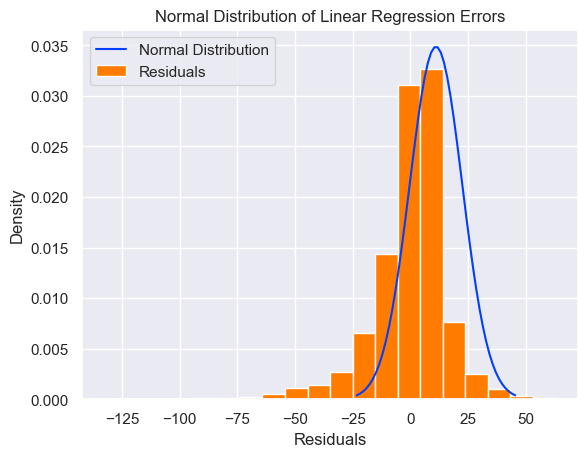

In [61]:
plt.plot(x, pdf, label='Normal Distribution')
plt.hist(test_df["regression_error"], density=True, bins=20, alpha=1, label='Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Normal Distribution of Linear Regression Errors')
plt.legend()
plt.show()

Now lets see how linear regression perform when we include more variables in the model with the 5K timings.

In [62]:
reg = LinearRegression()      # We are using sklearn as it is mentioned that we can use sklearn for Linear Regression
reg.fit(train_df[['5k_minutes', "Age"]], train_df['tot_minutes'])  # Training the model with training dataset

LinearRegression()

In [63]:
reg.coef_   # Coefficient of x and y in the equation of the plane

array([9.0742455 , 0.18284858])

In [64]:
reg.intercept_    # Value of the interceot at y-axis

-13.291616418217501

Now using the above line we can try to predict the finish time of the runners in the test dataset.

In [65]:
test_df["regression_2"] = reg.predict(test_df[['5k_minutes', "Age"]])

In [66]:
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_minutes,regression,regression_error,regression_2
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,03:48:56,00:08:44,16054,5886,682,228.933333,27.516667,244.310339,15.377005,244.995256
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,02:51:28,00:06:33,1085,1039,870,171.466667,18.500000,161.566646,-9.900020,161.347323
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,02:42:01,00:06:11,359,343,21,162.016667,18.516667,161.719592,-0.297075,162.047106
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,03:12:22,00:07:21,5149,515,449,192.366667,20.316667,178.237741,-14.128925,177.283656
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,03:49:11,00:08:45,16128,5935,1083,229.183333,25.033333,221.521410,-7.661923,221.180939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,...,02:39:59,00:06:07,271,257,239,159.983333,18.916667,165.390292,5.406959,164.396864
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,...,04:57:43,00:11:22,24817,13811,1410,297.716667,29.483333,262.357946,-35.358721,264.486909
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,...,03:11:55,00:07:20,5046,4559,2855,191.916667,22.200000,195.520620,3.603953,192.910697
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,...,03:48:55,00:08:44,16048,10167,1493,228.916667,24.233333,214.180011,-14.736656,215.932877


Now lets see how much error we get for each runner as compared to the actutal finish times.

In [67]:
test_df['regression_2_error'] = test_df['regression_2'] - df['tot_minutes']
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Pace,Overall,Gender,Division,tot_minutes,5k_minutes,regression,regression_error,regression_2,regression_2_error
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,00:08:44,16054,5886,682,228.933333,27.516667,244.310339,15.377005,244.995256,16.061922
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,00:06:33,1085,1039,870,171.466667,18.500000,161.566646,-9.900020,161.347323,-10.119344
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,00:06:11,359,343,21,162.016667,18.516667,161.719592,-0.297075,162.047106,0.030439
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,00:07:21,5149,515,449,192.366667,20.316667,178.237741,-14.128925,177.283656,-15.083010
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,00:08:45,16128,5935,1083,229.183333,25.033333,221.521410,-7.661923,221.180939,-8.002394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,...,00:06:07,271,257,239,159.983333,18.916667,165.390292,5.406959,164.396864,4.413531
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,...,00:11:22,24817,13811,1410,297.716667,29.483333,262.357946,-35.358721,264.486909,-33.229758
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,...,00:07:20,5046,4559,2855,191.916667,22.200000,195.520620,3.603953,192.910697,0.994030
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,...,00:08:44,16048,10167,1493,228.916667,24.233333,214.180011,-14.736656,215.932877,-12.983790


In the above dataframe the column "regression_error" gives us the difference between the predicted time and the actual time.

In [68]:
test_df['regression_2_error'].mean()    # Mean error of the predictions

0.0602530576836534

In [69]:
np.abs(test_df['regression_2_error']).describe() # The absolute mean, standatard deviation, min error, max error and other details

count    5260.000000
mean       11.037048
std        11.341894
min         0.008464
25%         3.864612
50%         7.887391
75%        14.211014
max       134.664037
Name: regression_2_error, dtype: float64

If we compare these results we can see that the error rate has dropped but not very much. Both the regression models are quite comparable.

Lets add another variable to the regression model. This time lets take the sex of the runner into consideration as well. We start by preprocessing of data. We start by label encoding the "M/F" columns in the dataframe to numerical one so that they can be fitted by our model which only take numerical data.

In [70]:
le = LabelEncoder()
train_df["sex"] = le.fit_transform(train_df["M/F"])
test_df["sex"] = le.fit_transform(test_df["M/F"])

In [71]:
train_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_minutes,sex
12649,22,F,USA,00:24:53,00:49:15,01:13:26,01:38:26,01:43:52,02:04:00,02:30:20,02:57:47,03:25:07,03:37:53,00:08:19,12704,3853,2834,217.883333,24.883333,0
24434,40,F,USA,00:32:18,01:04:14,01:36:36,02:12:27,02:19:49,02:51:45,03:27:42,04:05:50,04:40:33,04:55:11,00:11:16,24674,10920,1839,295.183333,32.300000,0
11083,47,F,USA,00:24:29,00:48:45,01:13:04,01:37:51,01:43:16,02:02:45,02:28:34,02:56:36,03:22:04,03:33:04,00:08:08,11123,2941,186,213.066667,24.483333,0
17255,40,M,USA,00:27:26,00:54:13,01:20:39,01:47:13,01:52:54,02:13:37,02:41:38,03:11:14,03:40:51,03:53:36,00:08:55,17371,10692,1676,233.600000,27.433333,1
19524,52,F,CAN,00:28:17,00:56:10,01:24:21,01:53:10,01:59:19,02:21:09,02:50:31,03:22:18,03:52:02,04:04:35,00:09:20,19670,8054,710,244.583333,28.283333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14519,27,F,USA,00:24:21,00:49:20,01:15:40,01:41:40,01:47:21,02:08:23,02:35:58,03:03:32,03:31:25,03:43:49,00:08:33,14594,4972,3365,223.816667,24.350000,0
16527,60,M,USA,00:26:05,00:52:00,01:18:51,01:45:17,01:50:56,02:11:41,02:39:03,03:08:07,03:37:32,03:51:05,00:08:49,16636,10399,313,231.083333,26.083333,1
24787,31,F,USA,00:32:34,01:04:02,01:36:51,02:11:24,02:18:46,02:47:20,03:25:35,04:06:08,04:44:54,05:02:15,00:11:32,25032,11134,5540,302.250000,32.566667,0
12006,33,F,CAN,00:25:39,00:50:34,01:15:32,01:40:14,01:45:40,02:05:36,02:31:44,02:57:48,03:24:09,03:35:50,00:08:14,12056,3483,2618,215.833333,25.650000,0


In [72]:
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Overall,Gender,Division,tot_minutes,5k_minutes,regression,regression_error,regression_2,regression_2_error,sex
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,16054,5886,682,228.933333,27.516667,244.310339,15.377005,244.995256,16.061922,0
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,1085,1039,870,171.466667,18.500000,161.566646,-9.900020,161.347323,-10.119344,1
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,359,343,21,162.016667,18.516667,161.719592,-0.297075,162.047106,0.030439,1
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,5149,515,449,192.366667,20.316667,178.237741,-14.128925,177.283656,-15.083010,0
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,16128,5935,1083,229.183333,25.033333,221.521410,-7.661923,221.180939,-8.002394,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,...,271,257,239,159.983333,18.916667,165.390292,5.406959,164.396864,4.413531,1
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,...,24817,13811,1410,297.716667,29.483333,262.357946,-35.358721,264.486909,-33.229758,1
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,...,5046,4559,2855,191.916667,22.200000,195.520620,3.603953,192.910697,0.994030,1
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,...,16048,10167,1493,228.916667,24.233333,214.180011,-14.736656,215.932877,-12.983790,1


In [73]:
reg = LinearRegression()      # We are using sklearn as it is mentioned that we can use sklearn for Linear Regression
reg.fit(train_df[['5k_minutes', "Age", "sex"]], train_df['tot_minutes'])  # Training the model with training dataset

LinearRegression()

In [74]:
reg.coef_   # Coefficient of the variables

array([ 9.06104398,  0.18657096, -0.29718763])

In [75]:
reg.intercept_    # Value of the intercept

-12.948731407647472

In [76]:
test_df["regression_3"] = reg.predict(test_df[['5k_minutes', "Age", "sex"]])

In [77]:
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Gender,Division,tot_minutes,5k_minutes,regression,regression_error,regression_2,regression_2_error,sex,regression_3
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,5886,682,228.933333,27.516667,244.310339,15.377005,244.995256,16.061922,0,245.149830
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,1039,870,171.466667,18.500000,161.566646,-9.900020,161.347323,-10.119344,1,161.286520
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,343,21,162.016667,18.516667,161.719592,-0.297075,162.047106,0.030439,1,161.997250
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,515,449,192.366667,20.316667,178.237741,-14.128925,177.283656,-15.083010,0,177.484891
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,5935,1083,229.183333,25.033333,221.521410,-7.661923,221.180939,-8.002394,0,221.342241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,...,257,239,159.983333,18.916667,165.390292,5.406959,164.396864,4.413531,1,164.315671
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,...,13811,1410,297.716667,29.483333,262.357946,-35.358721,264.486909,-33.229758,1,264.351835
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,...,4559,2855,191.916667,22.200000,195.520620,3.603953,192.910697,0.994030,1,192.760102
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,...,10167,1493,228.916667,24.233333,214.180011,-14.736656,215.932877,-12.983790,1,215.848499


Now lets see how much error we get for each runner as compared to the actutal finish times.

In [78]:
test_df['regression_3_error'] = test_df['regression_3'] - df['tot_minutes']
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Division,tot_minutes,5k_minutes,regression,regression_error,regression_2,regression_2_error,sex,regression_3,regression_3_error
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,682,228.933333,27.516667,244.310339,15.377005,244.995256,16.061922,0,245.149830,16.216497
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,870,171.466667,18.500000,161.566646,-9.900020,161.347323,-10.119344,1,161.286520,-10.180147
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,21,162.016667,18.516667,161.719592,-0.297075,162.047106,0.030439,1,161.997250,-0.019416
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,449,192.366667,20.316667,178.237741,-14.128925,177.283656,-15.083010,0,177.484891,-14.881775
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,1083,229.183333,25.033333,221.521410,-7.661923,221.180939,-8.002394,0,221.342241,-7.841092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,33,M,USA,00:18:55,00:38:04,00:56:51,01:15:50,01:19:52,01:34:19,01:53:22,...,239,159.983333,18.916667,165.390292,5.406959,164.396864,4.413531,1,164.315671,4.332338
24573,56,M,USA,00:29:29,00:58:28,01:28:54,01:59:04,02:06:13,02:32:15,03:09:20,...,1410,297.716667,29.483333,262.357946,-35.358721,264.486909,-33.229758,1,264.351835,-33.364832
5035,26,M,CAN,00:22:12,00:44:24,01:06:19,01:28:52,01:33:47,01:51:32,02:15:36,...,2855,191.916667,22.200000,195.520620,3.603953,192.910697,0.994030,1,192.760102,0.843436
15949,51,M,USA,00:24:14,00:49:29,01:14:26,01:39:55,01:45:29,02:05:41,02:34:04,...,1493,228.916667,24.233333,214.180011,-14.736656,215.932877,-12.983790,1,215.848499,-13.068168


Now lets see how much error we get for each runner as compared to the actutal finish times.

In [79]:
test_df['regression_3_error'].mean()    # Mean error of the predictions

0.05931384294424129

In [80]:
np.abs(test_df['regression_2_error']).describe() # The absolute mean, standatard deviation, min error, max error and other details

count    5260.000000
mean       11.037048
std        11.341894
min         0.008464
25%         3.864612
50%         7.887391
75%        14.211014
max       134.664037
Name: regression_2_error, dtype: float64

So in the above linear regression model in which we used 5K finish times, age and sex of the runners as input then the mean absolute error is about 11 minutes with standard deviation of about 11.3 minutes. The error rates are comparable with the above linear regression models. Lets see the graph of gaussian distribution of the errors.

In [81]:
mean = np.abs(test_df['regression_3_error']).mean()
std_dev = np.abs(test_df['regression_3_error']).std()
x_axis = test_df['regression_3_error']
x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 50)
pdf = norm.pdf(x, mean, std_dev)

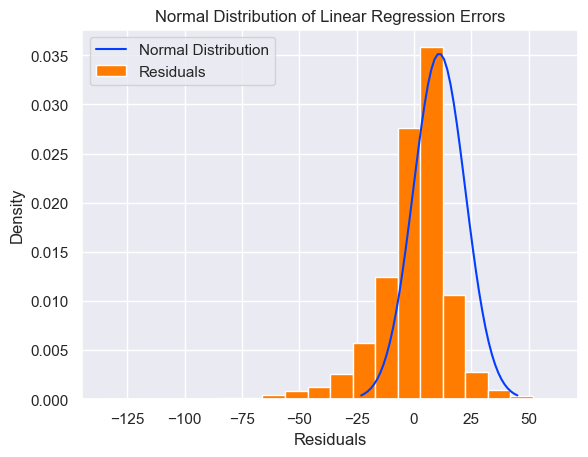

In [82]:
plt.plot(x, pdf, label='Normal Distribution')
plt.hist(test_df["regression_3_error"], density=True, bins=20, alpha=1, label='Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Normal Distribution of Linear Regression Errors')
plt.legend()
plt.show()

# Conclusion

We have created 1D KDE, 2D KDE models and compared both the models with k-NN models and we observed that 2D KDE models performs better than 1D KDE model with the given dataset. We also observed that the KDE models has better accuracy than the k-NN model for the given dataset. We observed how the accuracy of the model increases as we change the size of the training data and number of neighbours in k-NN model.

The linear regression model we have created to predict the finish time given that 5K time as an input is also quite accurate. We created three models. First where just the 5K finish time was given as input, second in which we have 5K timing and age of the runner was inputs and the third model in which 5K timing, age and sex of the runner were given as input. All three models gave mean absolute error of around 11 minutes.

We can observe that the linear regression model is helpful when we deal with continious data. For example, in our case we are predicting the finish time of the runners which is like a continious function. On the other hand, KDE and k-NN models are classification models in which we are predicting discrete outputs.

# References

1. Naive Bayes from sklearn, Accessed May 11, 2023. https://scikit-learn.org/stable/modules/naive_bayes.html
2. Class Notes. Accessed May 11, 2023.
3. Pandas API Library. Accessed May 11, 2023. https://pandas.pydata.org/docs/reference/frame.html.
4. Density Estimation. Accessed May 11, 2023. https://scikit-learn.org/stable/modules/density.html.
5. Linear Regression. Accessed May 11, 2023. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.
6. KNeighborsClassifier. Accessed May 11, 2023. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html.    
    